In [42]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    precision_recall_fscore_support,
)

In [43]:
DATA_DIR = "datasets/"
MODULE = "EEE"
PRESENTATION = "2014J"
EARLY_DAYS = 30   # <── CHỐT SỐ NGÀY 30

# =====================================================
# 2. LOAD DATA
# =====================================================
student_info = pd.read_csv(
    DATA_DIR + "studentInfo.csv",
    usecols=["id_student","code_module","code_presentation","final_result",
             "gender","age_band"]
)

student_reg = pd.read_csv(
    DATA_DIR + "studentRegistration.csv",
    usecols=["id_student","code_module","code_presentation","date_registration"]
)

student_vle = pd.read_csv(
    DATA_DIR + "studentVle.csv",
    usecols=["id_student","code_module","code_presentation","date","sum_click"]
)

student_ass = pd.read_csv(
    DATA_DIR + "studentAssessment.csv",
    usecols=["id_assessment","id_student","date_submitted","score"]
)

In [44]:
students = student_info[
    (student_info["code_module"] == MODULE) &
    (student_info["code_presentation"] == PRESENTATION)
].copy()

students["dropout"] = np.where(
    students["final_result"] == "Withdrawn", 1, 0
)

print("Tổng số học viên:", len(students))
print("Tỷ lệ bỏ học:", students["dropout"].mean())

Tổng số học viên: 1188
Tỷ lệ bỏ học: 0.25757575757575757


In [45]:
reg = student_reg[
    (student_reg["code_module"] == MODULE) &
    (student_reg["code_presentation"] == PRESENTATION) &
    (student_reg["id_student"].isin(students["id_student"]))
]

reg_features = reg[["id_student", "date_registration"]].rename(
    columns={"date_registration":"reg_day"}
)
reg_features["registered_before_start"] = (reg_features["reg_day"] < 0).astype(int)

In [46]:
vle = student_vle[
    (student_vle["code_module"] == MODULE) &
    (student_vle["code_presentation"] == PRESENTATION) &
    (student_vle["id_student"].isin(students["id_student"])) &
    (student_vle["date"] >= 0) &
    (student_vle["date"] <= EARLY_DAYS)
].copy()

# Tổng engagement
vle_agg = (
    vle.groupby("id_student")
    .agg(
        total_clicks=("sum_click","sum"),
        active_days=("date","nunique")
    )
    .reset_index()
)

vle_agg["avg_clicks_per_day"] = vle_agg["total_clicks"] / EARLY_DAYS
vle_agg["avg_clicks_per_active_day"] = (
    vle_agg["total_clicks"] / vle_agg["active_days"].replace(0,np.nan)
)
vle_agg["avg_clicks_per_active_day"] = vle_agg["avg_clicks_per_active_day"].fillna(0)

# Các cửa sổ theo mốc hành vi
window_defs = [
    (0,7,"clicks_0_7"),
    (8,14,"clicks_8_14"),
    (15,21,"clicks_15_21"),
    (22,EARLY_DAYS,f"clicks_22_{EARLY_DAYS}")
]

click_feature_names = []

def clicks_window(df,start,end,name):
    w = df[(df["date"]>=start)&(df["date"]<=end)] \
            .groupby("id_student")["sum_click"].sum() \
            .reset_index().rename(columns={"sum_click":name})
    return w

for start,end,col in window_defs:
    w = clicks_window(vle,start,end,col)
    vle_agg = vle_agg.merge(w,on="id_student",how="left")
    click_feature_names.append(col)

vle_agg[click_feature_names] = vle_agg[click_feature_names].fillna(0)

# days_since_last_login
last_active = vle.groupby("id_student")["date"].max().reset_index()
last_active["days_since_last_login"] = EARLY_DAYS - last_active["date"]

# inactivity_streak
vle_days = vle.groupby("id_student")["date"] \
              .apply(lambda x: sorted(x.unique())) \
              .reset_index()

def streak(lst,maxd):
    if not lst:
        return maxd+1
    s=set(lst)
    c=0; d=maxd
    while d>=0 and d not in s:
        c+=1; d-=1
    return c

vle_days["inactivity_streak"] = vle_days["date"].apply(
    lambda days: streak(days,EARLY_DAYS)
)

extra = last_active.merge(
    vle_days[["id_student","inactivity_streak"]],
    on="id_student"
)

vle_agg = vle_agg.merge(extra,on="id_student")

In [47]:
ass = student_ass[
    (student_ass["id_student"].isin(students["id_student"])) &
    (student_ass["date_submitted"] >= 0) &
    (student_ass["date_submitted"] <= EARLY_DAYS)
].copy()

ass_agg = (
    ass.groupby("id_student")
    .agg(
        num_assessments=("id_assessment","nunique"),
        avg_score=("score","mean"),
        max_score=("score","max"),
        min_score=("score","min"),
        score_std=("score","std")
    )
    .reset_index()
)

last_score = ass.sort_values(["id_student","date_submitted"]) \
    .groupby("id_student")["score"].last() \
    .reset_index().rename(columns={"score":"last_score"})

ass_agg = ass_agg.merge(last_score,on="id_student",how="left")

# pass_rate
ass["is_pass"] = (ass["score"] >= 40).astype(int)
pass_rate = ass.groupby("id_student")["is_pass"].mean().reset_index() \
               .rename(columns={"is_pass":"pass_rate"})
ass_agg = ass_agg.merge(pass_rate,on="id_student",how="left").fillna(0)

In [48]:
data = (
    students.merge(reg_features,on="id_student",how="left")
            .merge(vle_agg,on="id_student",how="left")
            .merge(ass_agg,on="id_student",how="left")
)

In [49]:
numeric_cols = [
    "reg_day","registered_before_start",
    "total_clicks","active_days",
    "avg_clicks_per_day","avg_clicks_per_active_day",
] + click_feature_names + [
    "num_assessments","avg_score","max_score","min_score",
    "score_std","last_score","pass_rate",
    "days_since_last_login","inactivity_streak"
]

for col in numeric_cols:
    data[col] = data[col].fillna(0)

print("Nan count:\n", data.isna().sum())


Nan count:
 code_module                    0
code_presentation              0
id_student                     0
gender                         0
age_band                       0
final_result                   0
dropout                        0
reg_day                        0
registered_before_start        0
total_clicks                   0
active_days                    0
avg_clicks_per_day             0
avg_clicks_per_active_day      0
clicks_0_7                     0
clicks_8_14                    0
clicks_15_21                   0
clicks_22_30                   0
date                         131
days_since_last_login          0
inactivity_streak              0
num_assessments                0
avg_score                      0
max_score                      0
min_score                      0
score_std                      0
last_score                     0
pass_rate                      0
dtype: int64


In [50]:
feature_cols_num = numeric_cols

feature_cols_cat = [
    "gender",
    "age_band"
]

X = data[feature_cols_num + feature_cols_cat]
y = data["dropout"]

X_train,X_test,y_train,y_test = train_test_split(
    X,y,test_size=0.3,random_state=42,stratify=y
)

print("EARLY_DAYS:",EARLY_DAYS)
print("Train/Test shape:", X_train.shape, X_test.shape)
print("Dropout ratio:", y_train.mean(), y_test.mean())

EARLY_DAYS: 30
Train/Test shape: (831, 21) (357, 21)
Dropout ratio: 0.2575210589651023 0.25770308123249297


In [51]:
numeric_tf = Pipeline([
    ("scale", StandardScaler())
])

cat_tf = Pipeline([
    ("oh", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_tf, feature_cols_num),
    ("cat", cat_tf, feature_cols_cat),
])

models = {
    "LogisticRegression": LogisticRegression(
        penalty="l1",solver="saga",max_iter=1200
    ),
    "RandomForest": RandomForestClassifier(
        max_depth=3,min_samples_split=50,
        min_samples_leaf=10,n_estimators=50
    ),
    "GradientBoosting": GradientBoostingClassifier(
        learning_rate=0.03,max_depth=3,
        min_samples_split=20,n_estimators=10
    ),
    "MLPClassifier": MLPClassifier(
        hidden_layer_sizes=(135,),solver="sgd",
        learning_rate_init=0.3,early_stopping=True,
        max_iter=1200
    ),
}


In [52]:
results = {}

for name,clf in models.items():
    print(f"\n===== EARLY 30 DAYS | Model: {name} =====")
    
    pipe = Pipeline([
        ("prep",preprocessor),
        ("clf",clf),
    ])

    pipe.fit(X_train,y_train)

    y_pred  = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]

    acc = accuracy_score(y_test,y_pred)
    prec,rec,f1,_ = precision_recall_fscore_support(
        y_test,y_pred,labels=[1]
    )
    auc = roc_auc_score(y_test,y_proba)
    avgp = average_precision_score(y_test,y_proba)

    print("Accuracy:",acc)
    print("Precision:",prec[0])
    print("Recall:",rec[0])
    print("F1:",f1[0])
    print("ROC AUC:",auc)
    print("Average Precision:",avgp)

    print("\nReport:")
    print(classification_report(y_test,y_pred))

    results[name] = {
        "accuracy":acc,
        "precision":prec[0],
        "recall":rec[0],
        "f1":f1[0],
        "roc_auc":auc,
        "avg_precision":avgp,
    }

results_df = pd.DataFrame(results).T
results_df



===== EARLY 30 DAYS | Model: LogisticRegression =====
Accuracy: 0.8431372549019608
Precision: 0.8333333333333334
Recall: 0.4891304347826087
F1: 0.6164383561643836
ROC AUC: 0.858121410992617
Average Precision: 0.7606025534984525

Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       265
           1       0.83      0.49      0.62        92

    accuracy                           0.84       357
   macro avg       0.84      0.73      0.76       357
weighted avg       0.84      0.84      0.83       357


===== EARLY 30 DAYS | Model: RandomForest =====
Accuracy: 0.8403361344537815
Precision: 0.8431372549019608
Recall: 0.4673913043478261
F1: 0.6013986013986014
ROC AUC: 0.8619770303527481
Average Precision: 0.7750711201611213

Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       265
           1       0.84      0.47      0.60        92

    accuracy                          

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

Accuracy: 0.8543417366946778
Precision: 0.8703703703703703
Recall: 0.5108695652173914
F1: 0.6438356164383562
ROC AUC: 0.8597621000820345
Average Precision: 0.7674013010646377

Report:
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       265
           1       0.87      0.51      0.64        92

    accuracy                           0.85       357
   macro avg       0.86      0.74      0.78       357
weighted avg       0.86      0.85      0.84       357



,accuracy,precision,recall,f1,roc_auc,avg_precision
LogisticRegression,0.843137,0.833333,0.489130,0.616438,0.858121,0.760603
RandomForest,0.840336,0.843137,0.467391,0.601399,0.861977,0.775071
GradientBoosting,0.742297,0.000000,0.000000,0.000000,0.842884,0.727839
MLPClassifier,0.854342,0.870370,0.510870,0.643836,0.859762,0.767401


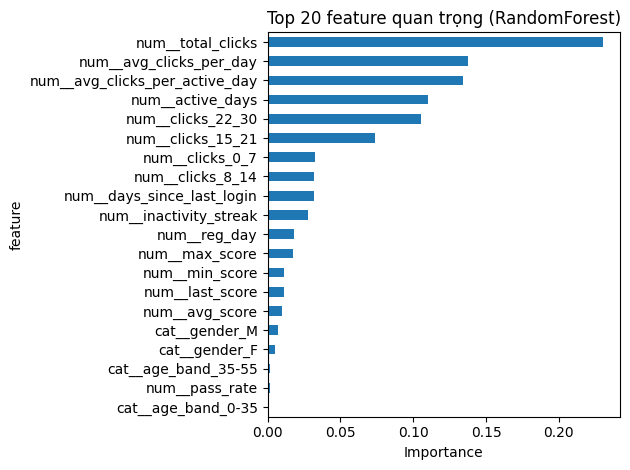

In [53]:
rf_clf = RandomForestClassifier(
    criterion="gini",
    max_depth=3,
    min_samples_leaf=10,
    min_samples_split=50,
    n_estimators=50,
)
rf_pipe = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("classifier", rf_clf),
    ]
)
rf_pipe.fit(X_train, y_train)

# Lấy tên feature sau khi OneHot + Scale
feature_names = rf_pipe.named_steps["preprocess"].get_feature_names_out()
importances = rf_pipe.named_steps["classifier"].feature_importances_

fi = pd.DataFrame(
    {"feature": feature_names, "importance": importances}
).sort_values("importance", ascending=False)

top_n = 20
plt.figure()
fi.head(top_n).set_index("feature")["importance"].plot(
    kind="barh",
)
plt.gca().invert_yaxis()
plt.title(f"Top {top_n} feature quan trọng (RandomForest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()